In [1]:
import requests

try:
    response = requests.get("https://www.google.com", timeout=10)
    print("✅ Internet access works! Status code:", response.status_code)
except Exception as e:
    print("❌ No Internet access:", e)


✅ Internet access works! Status code: 200


🚀 Libraries loaded.
📦 Starting S3 download...
✅ S3 download completed.
📊 Loading and preprocessing data...
✅ Data loaded and preprocessed.
🧠 Defining model class...
✅ Model class defined.
🛠 Creating model instance...
✅ Model instance created on cpu
📥 Loading model weights...
⚠️ Warning: Model weights not found. Using random weights.
🔮 Running forecast...
✅ Forecasting complete.
🔁 Inverse transform complete.
📋 Forecasted DataFrame ready:
        Date    Day      AWND      PRCP       TAVG       TMAX       TMIN  \
0 2025-03-31  Day 1  0.735591 -0.039110  48.395954  52.736713  43.274277   
1 2025-04-01  Day 2  0.579844 -0.041139  48.375290  52.993172  43.183441   
2 2025-04-02  Day 3  0.501088 -0.040989  48.376072  53.019386  43.144146   
3 2025-04-03  Day 4  0.456846 -0.041140  48.391804  52.985867  43.121712   
4 2025-04-04  Day 5  0.429019 -0.041514  48.409019  52.947823  43.106075   
5 2025-04-05  Day 6  0.410585 -0.041963  48.423149  52.918602  43.094341   
6 2025-04-06  Day 7  0.3982

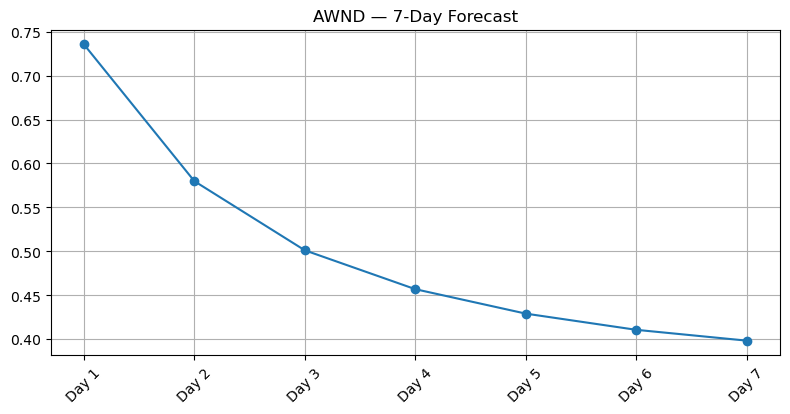

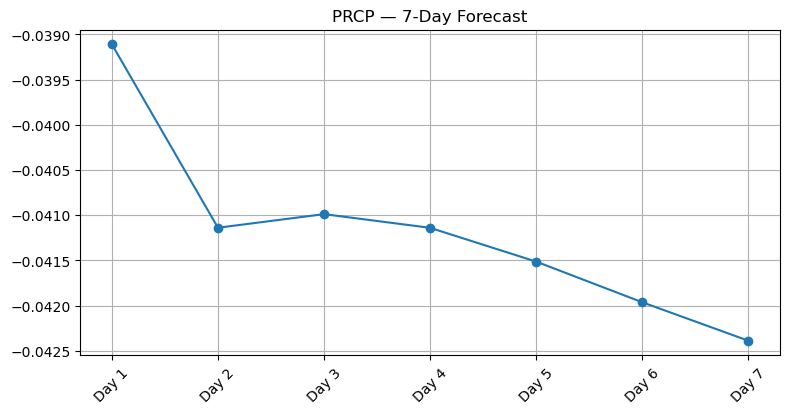

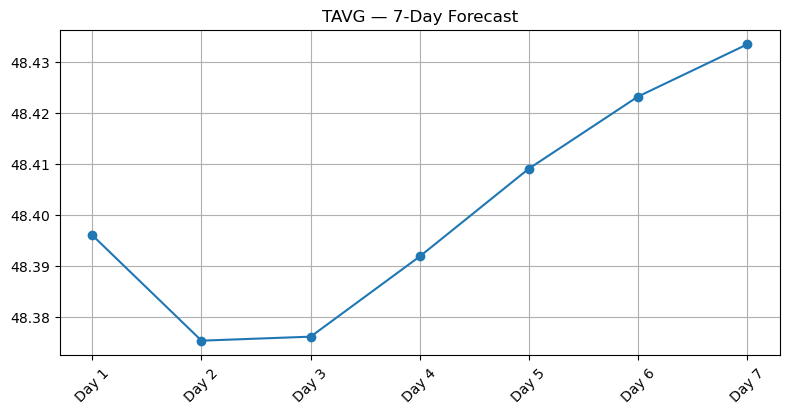

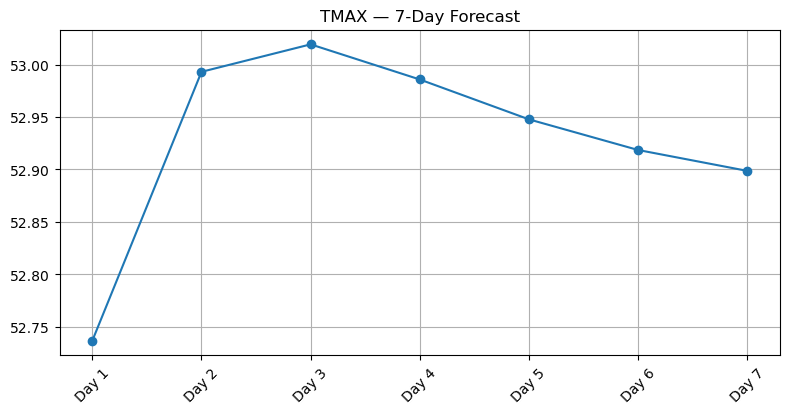

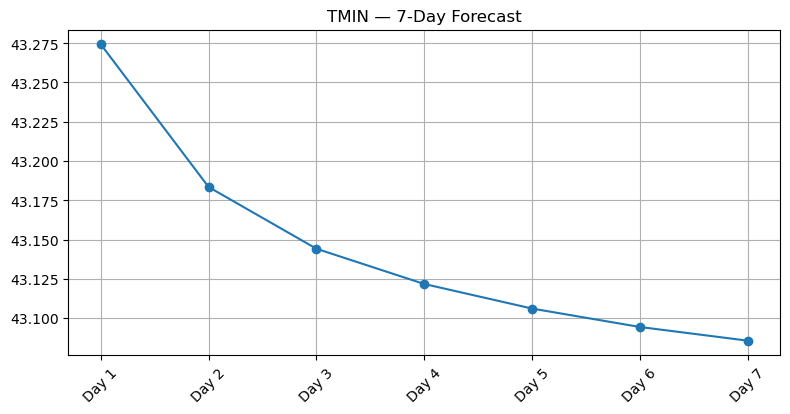

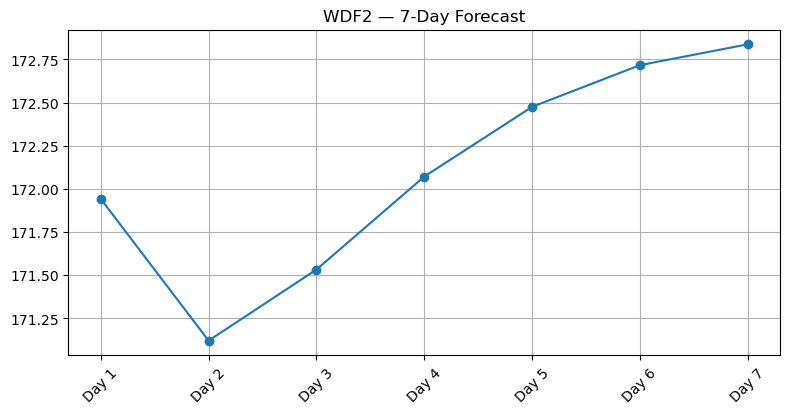

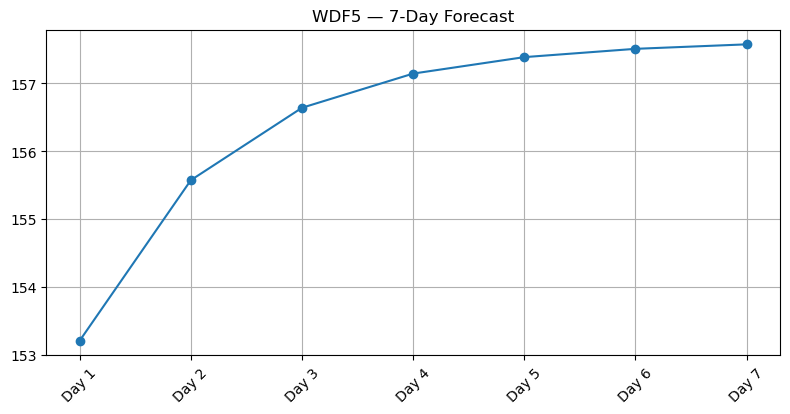

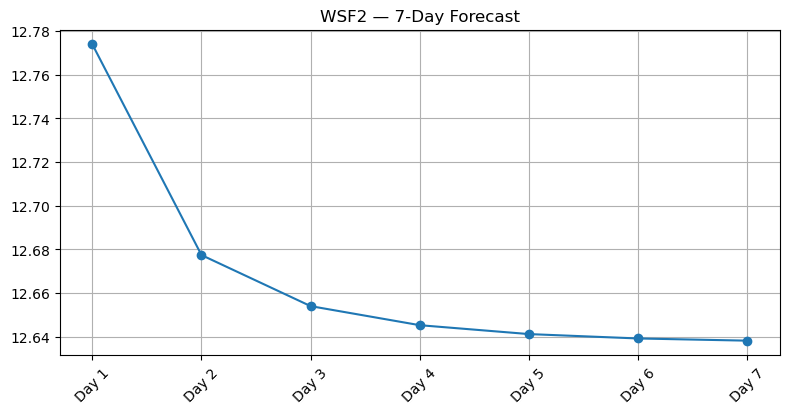

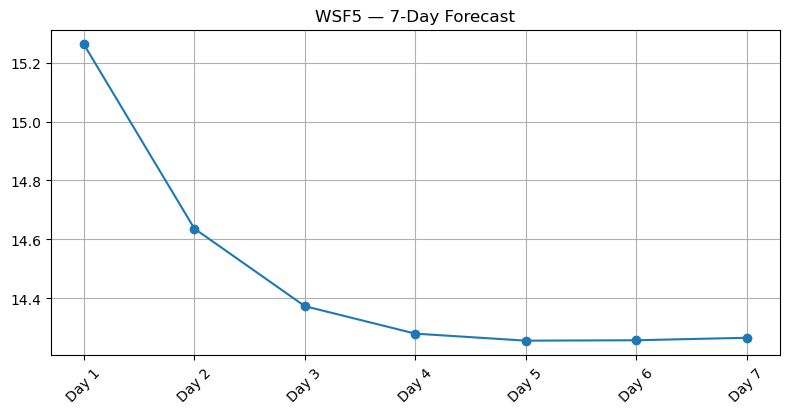

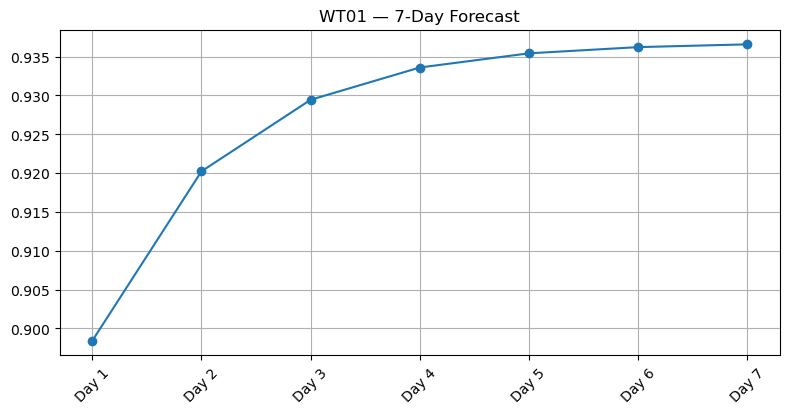

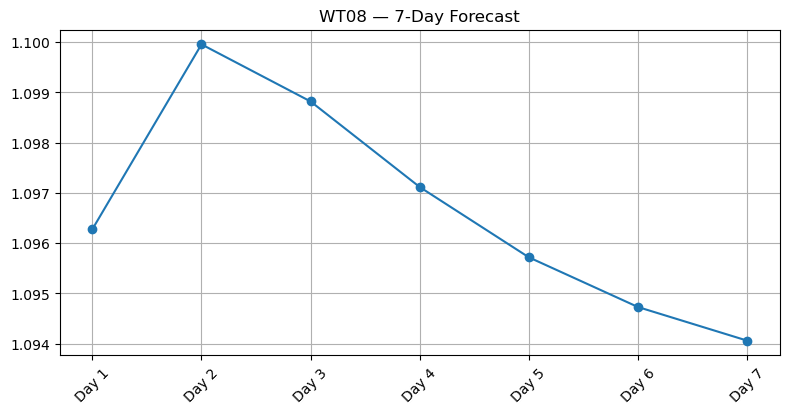

✅ All plots rendered.


In [5]:
# === Import libraries ===
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import boto3
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

print("🚀 Libraries loaded.")

# === CONFIG: AWS S3 ===
bucket = "kinesis-lambda-s3-bucket1"
key = "cleaned/cleaned_weather_dataset.csv"
local_file = "cleaned_weather_dataset.csv"

print("📦 Starting S3 download...")
s3 = boto3.client("s3")
s3.download_file(bucket, key, local_file)
print("✅ S3 download completed.")

# === Load & Preprocess Data ===
print("📊 Loading and preprocessing data...")
df = pd.read_csv(local_file)
df = df.fillna(df.mean(numeric_only=True))
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

features = ['AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 
            'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT08']

all_data = df[features].values
scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(all_data)
future_input = scaled_all[-14:]

print("✅ Data loaded and preprocessed.")

# === Define the LSTMForecast model ===
print("🧠 Defining model class...")
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h, c) = self.encoder(x)
        decoder_input = x[:, -1:, :]
        outputs = []
        for _ in range(7):  # 7-day forecast
            out, (h, c) = self.decoder(decoder_input, (h, c))
            step_output = self.output_layer(out[:, -1, :])
            outputs.append(step_output.unsqueeze(1))
            decoder_input = step_output.unsqueeze(1)
        return torch.cat(outputs, dim=1)

print("✅ Model class defined.")

# === Create the model ===
print("🛠 Creating model instance...")
device = torch.device("cpu")
model = LSTMForecast(input_size=11, hidden_size=64, output_size=11).to(device)
print("✅ Model instance created on", device)

# === (Optional) Load Pre-trained Weights ===
try:
    print("📥 Loading model weights...")
    model.load_state_dict(torch.load("lstm_multivariate_7day.pth", map_location=device))
    model.eval()
    print("✅ Model weights loaded.")
except FileNotFoundError:
    print("⚠️ Warning: Model weights not found. Using random weights.")

# === Forecast the Next 7 Days ===
print("🔮 Running forecast...")
input_tensor = torch.FloatTensor(future_input).unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(input_tensor).cpu().numpy().squeeze()

print("✅ Forecasting complete.")

# === Inverse Transform to Original Scale ===
predicted = scaler.inverse_transform(prediction)
print("🔁 Inverse transform complete.")

# === Generate Future Dates and Labels ===
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)
day_labels = [f"Day {i+1}" for i in range(7)]

# === Create Prediction DataFrame ===
df_pred = pd.DataFrame(predicted, columns=features)
df_pred.insert(0, "Date", future_dates)
df_pred.insert(1, "Day", day_labels)

print("📋 Forecasted DataFrame ready:")
print(df_pred)

# === Visualization ===
print("📈 Generating plots...")
for feature in features:
    plt.figure(figsize=(8, 4))
    plt.plot(df_pred['Day'], df_pred[feature], marker='o', label='Predicted')
    plt.title(f'{feature} — 7-Day Forecast')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()
print("✅ All plots rendered.")


In [5]:
# === IMPORTS ===
import boto3
import torch
import torch.nn as nn

# === DEFINE MODEL CLASS ===
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h, c) = self.encoder(x)
        decoder_input = x[:, -1:, :]
        outputs = []
        for _ in range(7):  # 7-day forecast
            out, (h, c) = self.decoder(decoder_input, (h, c))
            step_output = self.output_layer(out[:, -1, :])
            outputs.append(step_output.unsqueeze(1))
            decoder_input = step_output.unsqueeze(1)
        return torch.cat(outputs, dim=1)

# === SETUP ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
s3 = boto3.client("s3")

# === DOWNLOAD MODEL FILE FROM S3 ===
try:
    print("⏬ Downloading model file from S3...")
    s3.download_file(
        'kinesis-lambda-s3-bucket1',
        'pth/lstm_multivariate_7day.pth',
        'lstm_multivariate_7day.pth'
    )
    print("✅ Model file downloaded from S3.")
except Exception as e:
    print("❌ S3 Download Failed:", e)

# === INITIALIZE MODEL ===
model = LSTMForecast(input_size=11, hidden_size=64, output_size=11).to(device)

# === LOAD SAVED STATE ===
try:
    model.load_state_dict(torch.load("lstm_multivariate_7day.pth", map_location=device))
    model.eval()
    print("✅ Model weights loaded successfully.")
except Exception as e:
    print("❌ Failed to load model weights:", e)


⏬ Downloading model file from S3...
✅ Model file downloaded from S3.
✅ Model weights loaded successfully.



📊 7-Day Forecast:
        Date    Day      AWND      PRCP       TAVG       TMAX       TMIN  \
0 2025-03-31  Day 1  4.850648 -0.014450  50.058090  55.629971  46.709236   
1 2025-04-01  Day 2  4.937140 -0.021527  50.260761  56.200191  46.770908   
2 2025-04-02  Day 3  4.970750 -0.025294  50.336994  56.557323  46.841568   
3 2025-04-03  Day 4  4.988823 -0.028425  50.386120  56.757660  46.891338   
4 2025-04-04  Day 5  5.001479 -0.030657  50.411568  56.854244  46.916500   
5 2025-04-05  Day 6  5.010020 -0.032152  50.421967  56.888680  46.923645   
6 2025-04-06  Day 7  5.014613 -0.033116  50.423672  56.889278  46.919762   

         WDF2        WDF5       WSF2       WSF5      WT01      WT08  
0  214.005875  209.082596  21.967213  23.266457  0.917359  1.147423  
1  218.610916  212.572708  22.138950  23.667606  0.915875  1.143919  
2  221.398575  213.888306  22.352530  23.681404  0.915667  1.137437  
3  222.705002  214.219223  22.472002  23.600706  0.915555  1.130244  
4  223.226791  214.154

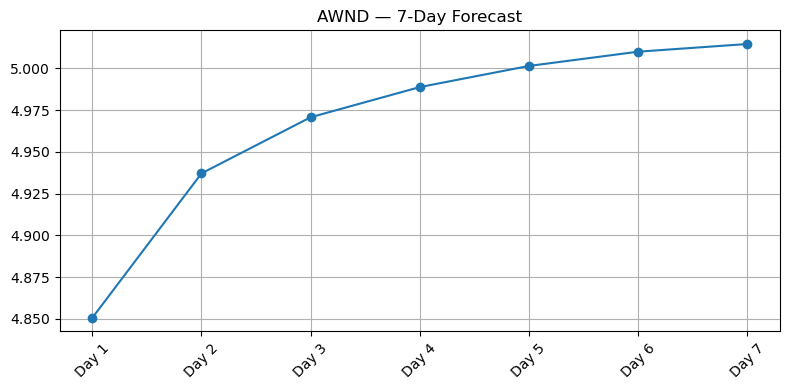

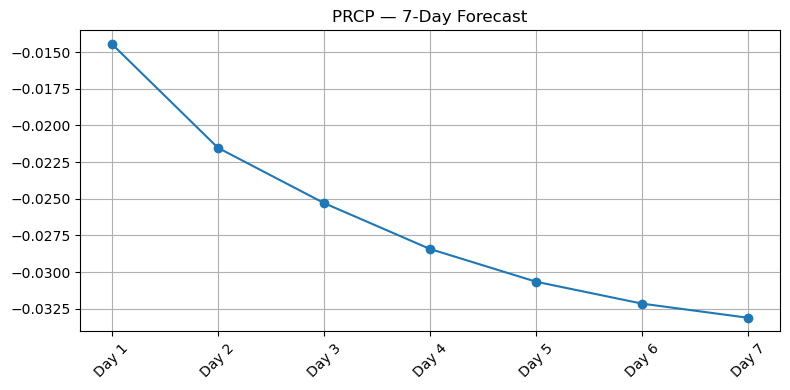

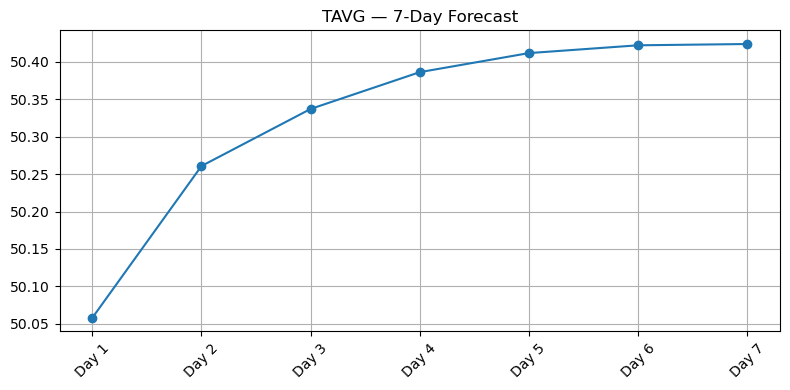

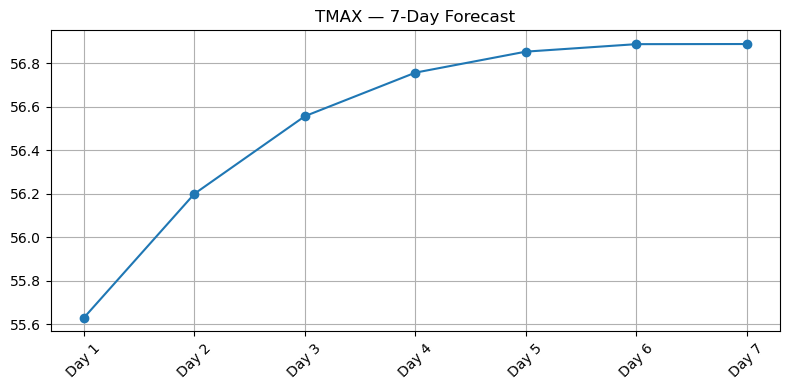

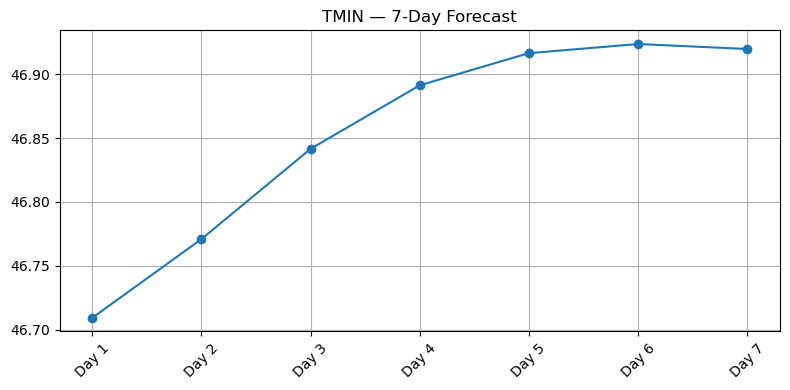

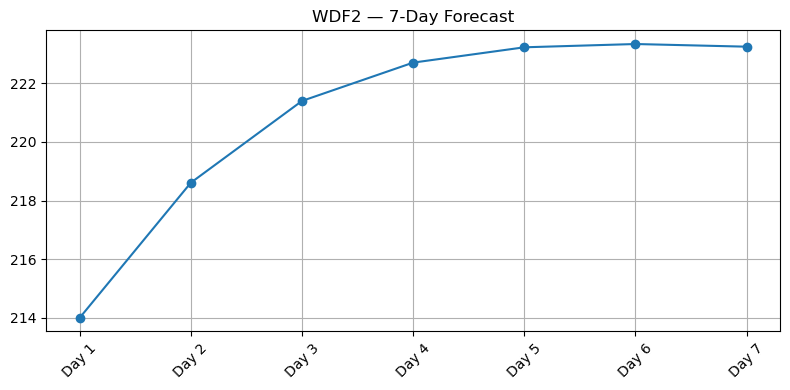

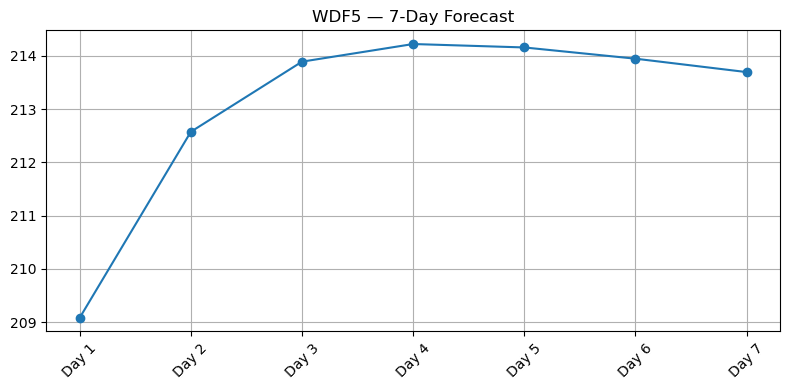

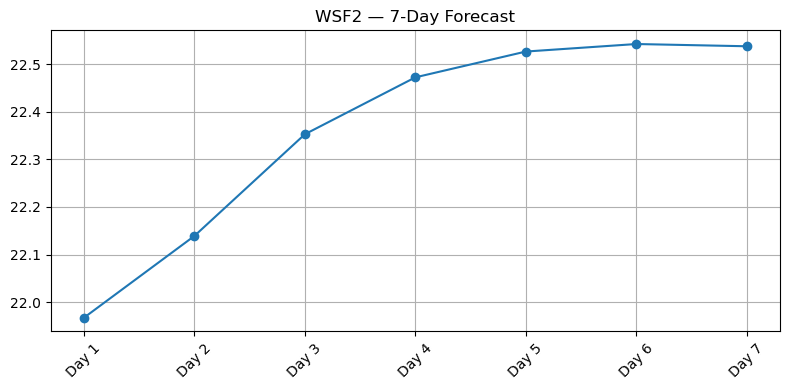

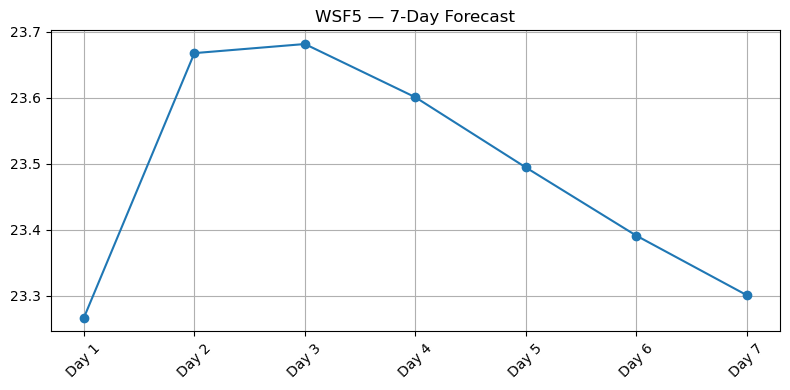

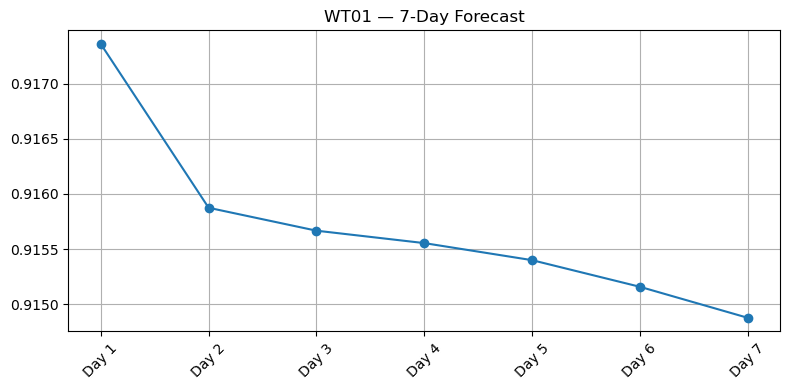

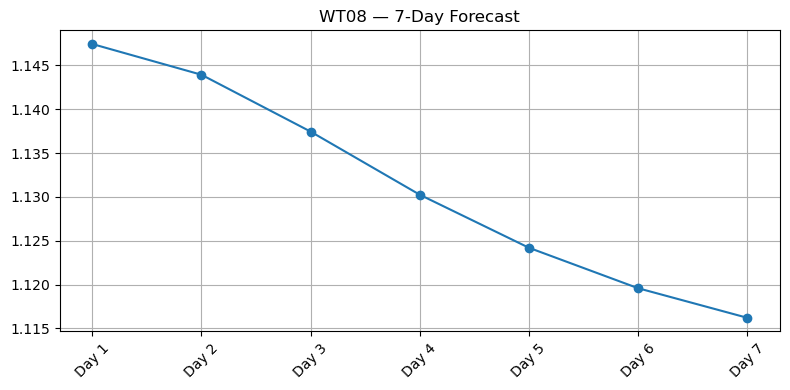

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# === Load & Preprocess Cleaned Dataset ===
df = pd.read_csv("cleaned_weather_dataset.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df = df.fillna(df.mean(numeric_only=True))

features = ['AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT08']
data = df[features].values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
last_14_days = scaled[-14:]

# === Convert to Tensor ===
input_tensor = torch.FloatTensor(last_14_days).unsqueeze(0).to(device)

# === Run Forecast ===
with torch.no_grad():
    forecast = model(input_tensor).cpu().numpy().squeeze()

predicted = scaler.inverse_transform(forecast)

# === Prepare Output DataFrame ===
future_dates = pd.date_range(df['date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
forecast_df = pd.DataFrame(predicted, columns=features)
forecast_df.insert(0, "Date", future_dates)
forecast_df.insert(1, "Day", [f"Day {i+1}" for i in range(7)])

# === Show Forecast ===
print("\n📊 7-Day Forecast:")
print(forecast_df)

# === Plot Features ===
for feature in features:
    plt.figure(figsize=(8, 4))
    plt.plot(forecast_df['Day'], forecast_df[feature], marker='o')
    plt.title(f'{feature} — 7-Day Forecast')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn

# === Load Dataset ===
df = pd.read_csv("cleaned_weather_dataset.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# === Define Constants ===
features = ['AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN',
            'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT08']
INPUT_DAYS = 14
PREDICT_DAYS = 7

# === Scale Data ===
scaler = MinMaxScaler()
all_data = df[features].values
scaled_all = scaler.fit_transform(all_data)
future_input = scaled_all[-INPUT_DAYS:]

# === Define Model ===
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h, c) = self.encoder(x)
        decoder_input = x[:, -1:, :]
        outputs = []
        for _ in range(PREDICT_DAYS):
            out, (h, c) = self.decoder(decoder_input, (h, c))
            step_output = self.output_layer(out[:, -1, :])
            outputs.append(step_output.unsqueeze(1))
            decoder_input = step_output.unsqueeze(1)
        return torch.cat(outputs, dim=1)

# === Load Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMForecast(input_size=11, hidden_size=64, output_size=11).to(device)
model.load_state_dict(torch.load("lstm_multivariate_7day.pth", map_location=device))
model.eval()

# === Run Prediction ===
input_tensor = torch.FloatTensor(future_input).unsqueeze(0).to(device)
with torch.no_grad():
    prediction = model(input_tensor).cpu().numpy().squeeze()

predicted = scaler.inverse_transform(prediction)

# === Format Output ===
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=PREDICT_DAYS)
day_labels = [f"Day {i+1}" for i in range(PREDICT_DAYS)]

df_pred = pd.DataFrame(predicted, columns=features)
df_pred.insert(0, "Date", future_dates)
df_pred.insert(1, "Day", day_labels)

# === Save to CSV ===
df_pred.to_csv("forecast_7day.csv", index=False)
print("✅ Saved forecast as 'forecast_7day.csv'")


✅ Saved forecast as 'forecast_7day.csv'



✅ Forecast saved to 'forecast_7day.csv'

📊 7-Day Forecast:
        Date    Day      AWND      PRCP       TAVG       TMAX       TMIN  \
0 2025-03-31  Day 1  4.850648 -0.014450  50.058090  55.629971  46.709236   
1 2025-04-01  Day 2  4.937140 -0.021527  50.260761  56.200191  46.770908   
2 2025-04-02  Day 3  4.970750 -0.025294  50.336994  56.557323  46.841568   
3 2025-04-03  Day 4  4.988823 -0.028425  50.386120  56.757660  46.891338   
4 2025-04-04  Day 5  5.001479 -0.030657  50.411568  56.854244  46.916500   
5 2025-04-05  Day 6  5.010020 -0.032152  50.421967  56.888680  46.923645   
6 2025-04-06  Day 7  5.014613 -0.033116  50.423672  56.889278  46.919762   

         WDF2        WDF5       WSF2       WSF5      WT01      WT08  
0  214.005875  209.082596  21.967213  23.266457  0.917359  1.147423  
1  218.610916  212.572708  22.138950  23.667606  0.915875  1.143919  
2  221.398575  213.888306  22.352530  23.681404  0.915667  1.137437  
3  222.705002  214.219223  22.472002  23.600706  0.

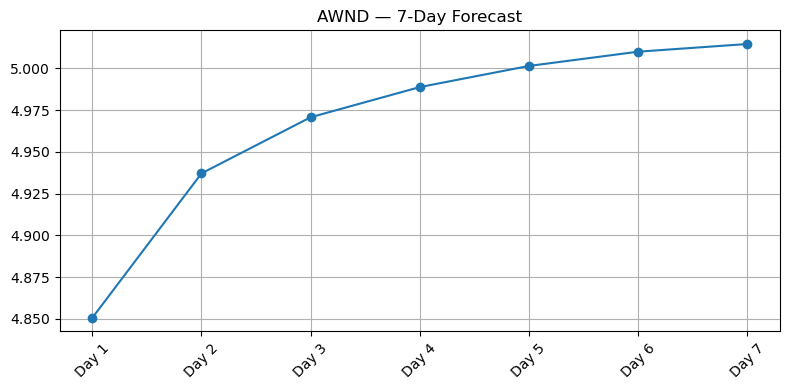

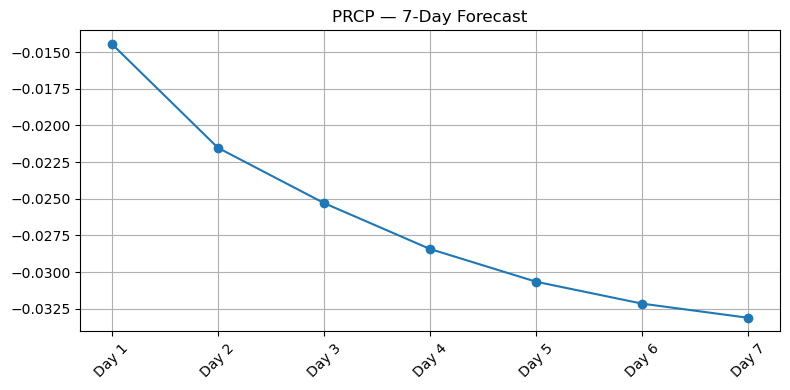

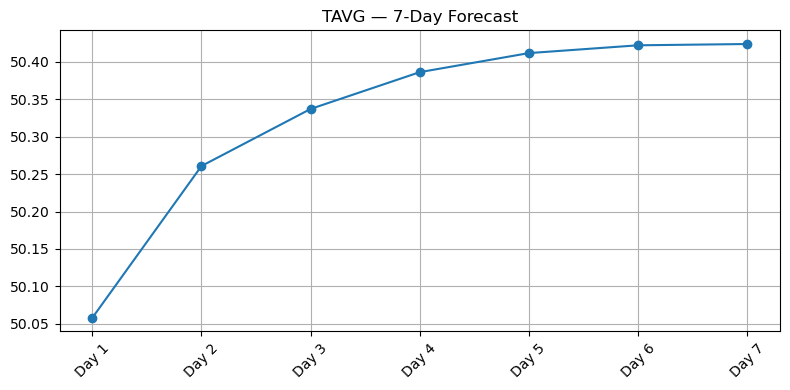

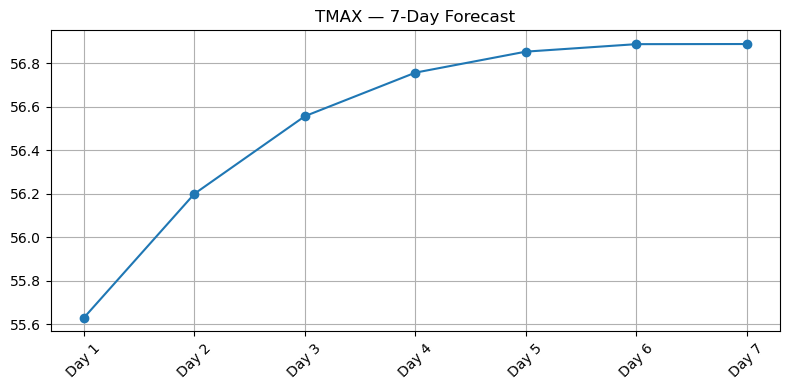

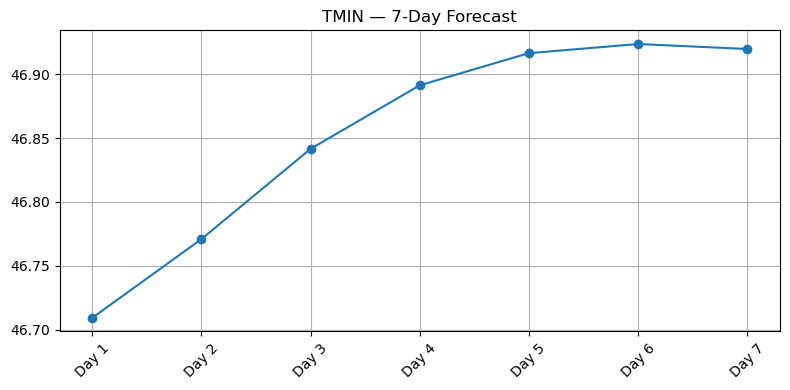

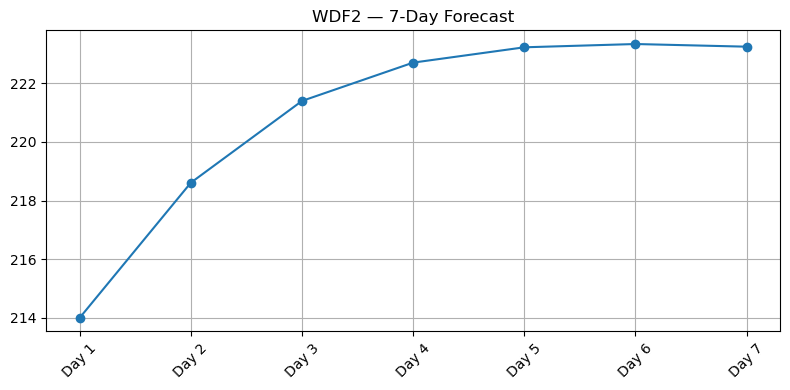

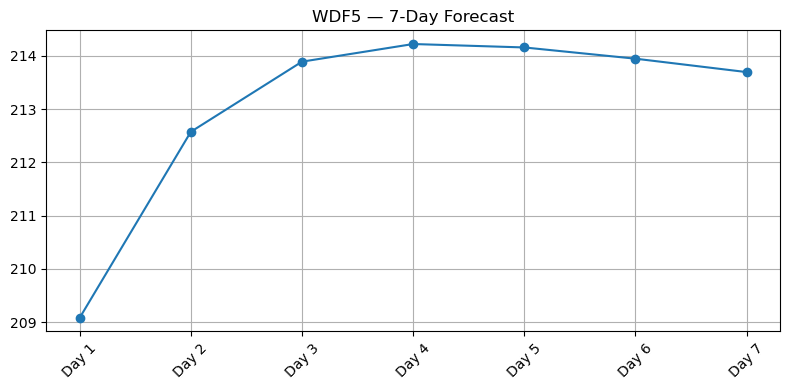

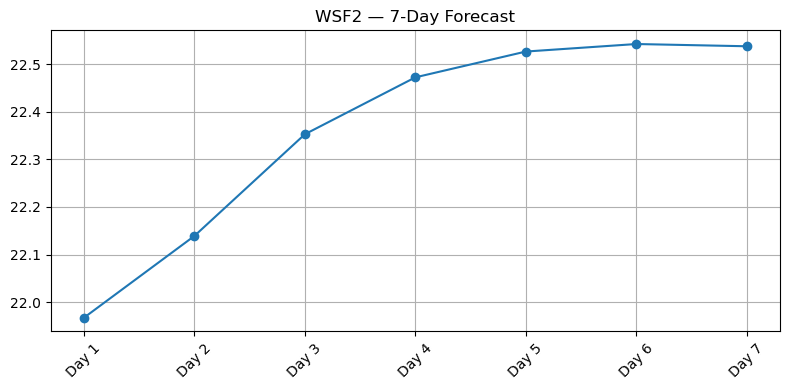

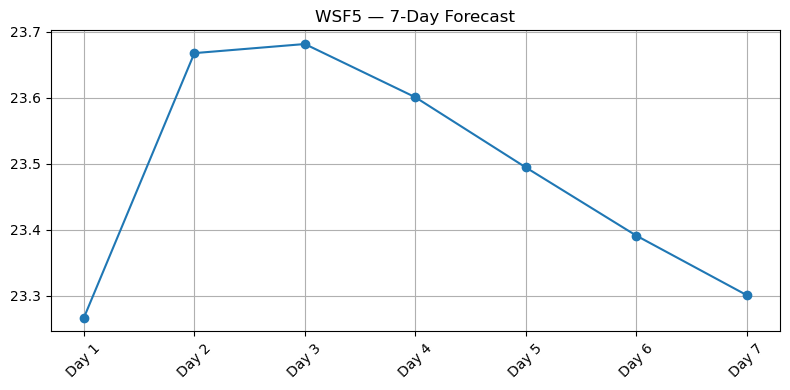

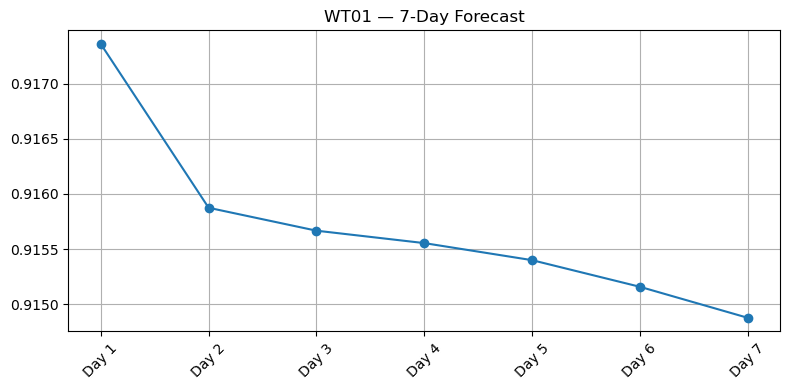

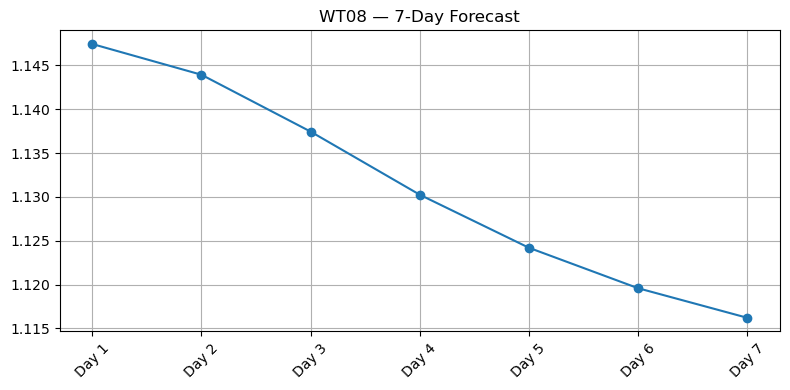

In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch import nn

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Define Model Architecture ===
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h, c) = self.encoder(x)
        decoder_input = x[:, -1:, :]
        outputs = []
        for _ in range(7):  # Forecast 7 days
            out, (h, c) = self.decoder(decoder_input, (h, c))
            step_output = self.output_layer(out[:, -1, :])
            outputs.append(step_output.unsqueeze(1))
            decoder_input = step_output.unsqueeze(1)
        return torch.cat(outputs, dim=1)

# === Load Model Weights ===
model = LSTMForecast(input_size=11, hidden_size=64, output_size=11).to(device)
model.load_state_dict(torch.load("lstm_multivariate_7day.pth", map_location=device))
model.eval()

# === Load & Preprocess Dataset ===
df = pd.read_csv("cleaned_weather_dataset.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df = df.fillna(df.mean(numeric_only=True))

features = ['AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN',
            'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT08']
data = df[features].values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# === Prepare Input ===
INPUT_DAYS = 14
last_14_days = scaled[-INPUT_DAYS:]
input_tensor = torch.FloatTensor(last_14_days).unsqueeze(0).to(device)

# === Run Model Forecast ===
with torch.no_grad():
    forecast = model(input_tensor).cpu().numpy().squeeze()

predicted = scaler.inverse_transform(forecast)

# === Format Output DataFrame ===
future_dates = pd.date_range(df['date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
forecast_df = pd.DataFrame(predicted, columns=features)
forecast_df.insert(0, "Date", future_dates)
forecast_df.insert(1, "Day", [f"Day {i+1}" for i in range(7)])

# === Save to CSV ===
forecast_df.to_csv("forecast_7day.csv", index=False)
print("\n✅ Forecast saved to 'forecast_7day.csv'")

# === Optional: Display & Plot ===
print("\n📊 7-Day Forecast:")
print(forecast_df)

for feature in features:
    plt.figure(figsize=(8, 4))
    plt.plot(forecast_df['Day'], forecast_df[feature], marker='o')
    plt.title(f'{feature} — 7-Day Forecast')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
